### i. Initialize project

In [54]:
import pandas as pd
import numpy as np        
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

#import file
banks_df = pd.read_csv('../data/bank-additional/bank-additional-full.csv', sep=';')


### ii. Preprocess Data

In [55]:
### Prepare data for experimentation
### by dropping columns already identifies as misc,
### binning and one-hot encoding categorical variables

# Drop previously engineered fields since we have no information about them;
# also drop day_of_week since little variance from day to day, 
# duration to prevent data leakage
# and housing since it highly correlated with loan
df = banks_df.drop(["day_of_week", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m","nr.employed","duration", "housing"], axis=1)

# Make varible for prior contact status
# set pdays null values to NAs
df["pdays_na"] = (df["pdays"] == 999).astype(int)
df['pdays'] = df['pdays'].replace(999, np.nan) 
# transform pdays to bins, since range 0-27, use 3 bins
df['pdays'] = pd.qcut(df['pdays'], q=3, labels=[1,2,3])


# Bin education to save dimensions
df["education"] = df["education"].map({
    "basic.4y": "primary",
    "basic.6y": "primary",
    "basic.9y": "secondary",
    "high.school": "secondary",
    "university.degree": "tertiary",
    "professional.course": "other",
    "unknown": "other",
    "illiterate": "other"
})
plt.show()
df['job'] = df['job'].replace('admin.', 'admin')


In [56]:

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=False)
# "job_unknown","marital_unknown","education_other","default_unknown","loan_unknown", "contact_telephone", "poutcome_nonexistent", "month_mar"
df_encoded = df_encoded.drop(columns=["y_yes", "y_no"])
df_encoded['y'] = df['y']

# column types
print('\nColumn Types and Non-null Values')
print('\n__Extended DF:__\n', df_encoded.info())


Column Types and Non-null Values
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   age                   41188 non-null  int64 
 1   campaign              41188 non-null  int64 
 2   previous              41188 non-null  int64 
 3   pdays_na              41188 non-null  int64 
 4   job_admin             41188 non-null  bool  
 5   job_blue-collar       41188 non-null  bool  
 6   job_entrepreneur      41188 non-null  bool  
 7   job_housemaid         41188 non-null  bool  
 8   job_management        41188 non-null  bool  
 9   job_retired           41188 non-null  bool  
 10  job_self-employed     41188 non-null  bool  
 11  job_services          41188 non-null  bool  
 12  job_student           41188 non-null  bool  
 13  job_technician        41188 non-null  bool  
 14  job_unemployed        41188 non-null  bool  
 15  jo

### iii. Split data into training and testing datasets

In [4]:

# create subsets for predictors (X) and dependent variable (y)
all_predictors =  df_encoded.drop(columns=["y"]).columns
X = df_encoded[all_predictors]
y = df_encoded["y"]

# split data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

# what are our distributions?
print("Original class distribution:\n", y.value_counts(normalize=True))
print("\nTraining set class distribution:\n", y_train.value_counts(normalize=True))
print("\nTesting set class distribution:\n", y_test.value_counts(normalize=True))


Original class distribution:
 y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Training set class distribution:
 y
no     0.887343
yes    0.112657
Name: proportion, dtype: float64

Testing set class distribution:
 y
no     0.887351
yes    0.112649
Name: proportion, dtype: float64


### iv.  Address data imbalance 

In [57]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"\nTraining set class distribution before SMOTE: {Counter(y_train)}")
print(f"\nTraining set class distribution after SMOTE: {Counter(y_train_resampled)}")


Training set class distribution before SMOTE: Counter({'no': 25583, 'yes': 3248})

Training set class distribution after SMOTE: Counter({'no': 25583, 'yes': 25583})


## 1. Decision Trees Experiments

### Build Baseline Decision Tree model

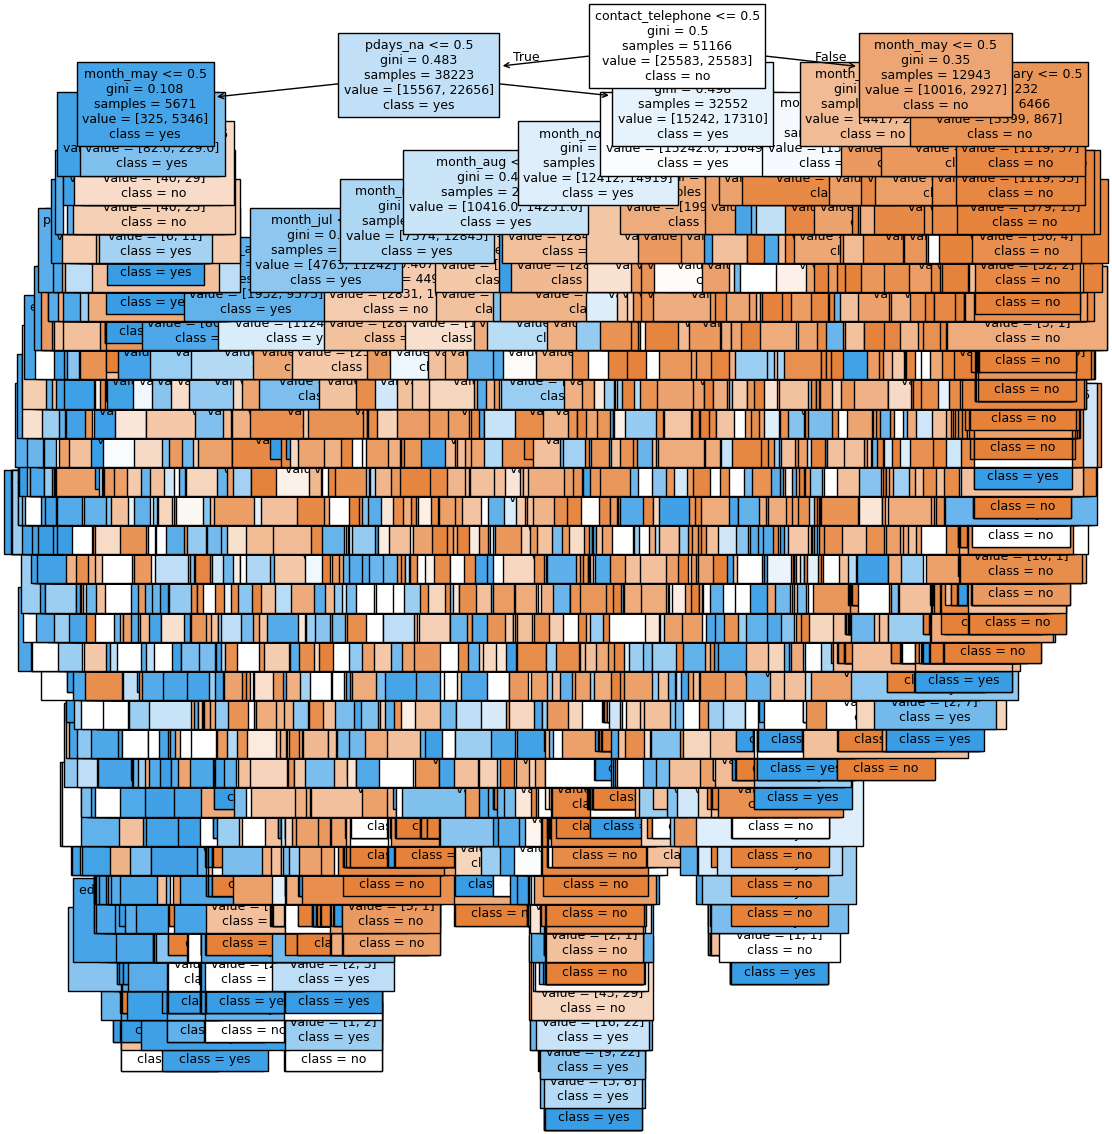

In [58]:
# build a full basic decision tree model using all parameters and defaul variables
dt0 = DecisionTreeClassifier(random_state=13, criterion='gini')
dt0.fit(X_train_resampled, y_train_resampled)

plt.figure(figsize=(12, 14))
plot_tree(dt0, 
               feature_names=all_predictors,
               class_names=dt0.classes_,
               filled=True, 
               fontsize=9)
plt.show()


In [59]:
# Output testing metrics for the base model
dt_y_pred = dt0.predict(X_test)
print('Confusion Matrix for Baseline Decision Tree\n', confusion_matrix(y_test, dt_y_pred))
print("\nAccuracy:", accuracy_score(y_test, dt_y_pred))
print('\nTesting Metrics for Baseline Decision Tree\n',classification_report(y_test, dt_y_pred))

# show the features sorted greastest by their importance to the base model
features = pd.DataFrame(dt0.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print('\n\nFeatures Sorted by Importance to Model\n', features.sort_values(by='importance', ascending=False))

Confusion Matrix for Baseline Decision Tree
 [[9827 1138]
 [ 957  435]]

Accuracy: 0.8304604677510723

Testing Metrics for Baseline Decision Tree
               precision    recall  f1-score   support

          no       0.91      0.90      0.90     10965
         yes       0.28      0.31      0.29      1392

    accuracy                           0.83     12357
   macro avg       0.59      0.60      0.60     12357
weighted avg       0.84      0.83      0.83     12357



Features Sorted by Importance to Model
                       importance
age                     0.136548
contact_telephone       0.106322
month_jul               0.075935
pdays_na                0.067417
campaign                0.048419
month_may               0.043855
month_aug               0.035362
default_unknown         0.033632
contact_cellular        0.031517
education_tertiary      0.029103
month_nov               0.029018
month_apr               0.026429
default_no              0.024811
month_jun             

### Q1.1 What happens when we randomnly choose an min_impurity_decrease value?

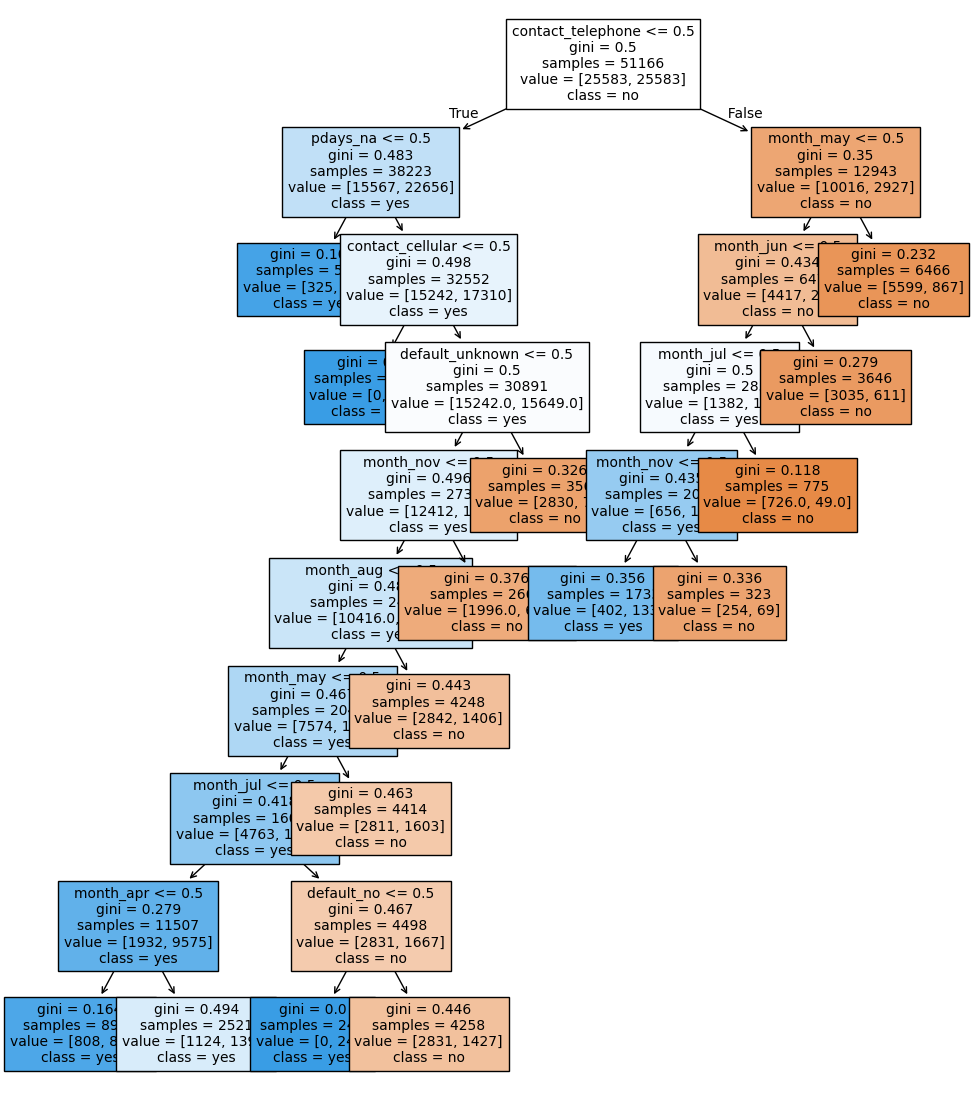

In [45]:
dt1 = DecisionTreeClassifier(random_state=13, criterion='gini', min_impurity_decrease=0.003)
dt1.fit(X_train_resampled, y_train_resampled)

plt.figure(figsize=(12, 14))
plot_tree(dt1, 
               feature_names=all_predictors,
               class_names=dt1.classes_,
               filled=True, 
               fontsize=10)
plt.show()

In [70]:
# Output testing metrics for the model with arbitrary stopping criterion
dt1_y_pred = dt1.predict(X_test)
print('Confusion Matrix for Baseline Decision Tree\n', confusion_matrix(y_test, dt1_y_pred))
print("\nAccuracy:", accuracy_score(y_test, dt1_y_pred))
print('\nTesting Metrics for Baseline Decision Tree\n',classification_report(y_test, dt1_y_pred))

# show the features sorted greastest by their importance to the base model
features = pd.DataFrame(dt1.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print('\n\nFeatures Sorted by Importance to Model\n', features.sort_values(by='importance', ascending=False))

print('# important features', len(features[features['importance'] > 0]))
print('Total features', len(features))

Confusion Matrix for Baseline Decision Tree
 [[9781 1184]
 [ 690  702]]

Accuracy: 0.8483450675730355

Testing Metrics for Baseline Decision Tree
               precision    recall  f1-score   support

          no       0.93      0.89      0.91     10965
         yes       0.37      0.50      0.43      1392

    accuracy                           0.85     12357
   macro avg       0.65      0.70      0.67     12357
weighted avg       0.87      0.85      0.86     12357



Features Sorted by Importance to Model
                       importance
contact_telephone       0.237649
month_jul               0.165247
pdays_na                0.149157
month_may               0.092853
contact_cellular        0.070186
default_unknown         0.066911
month_nov               0.062322
month_aug               0.057149
month_apr               0.045617
month_jun               0.034541
default_no              0.018368
month_dec               0.000000
loan_no                 0.000000
loan_unknown          

### Q1.2 - Can we improve the accuracy score for the base model by conducting post-pruning? If so, what should our CCP Value be?

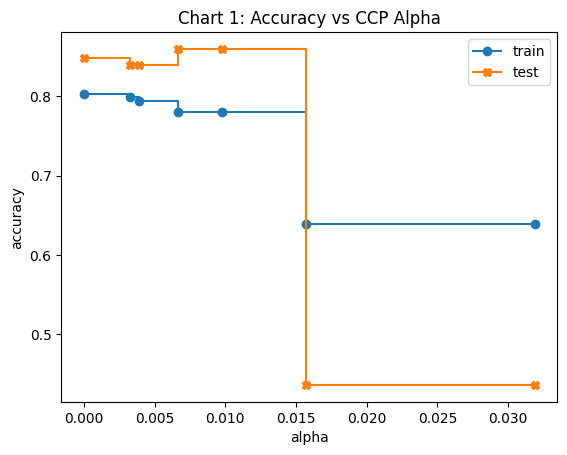

In [ ]:
# determine values for all alphas from our models ccp path
path = dt1.cost_complexity_pruning_path(X_train_resampled, y_train_resampled)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts = []
clf_alphas = []
# create a decision tree for each alpha value 
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha, criterion='gini', min_impurity_decrease=0.003)
    clf_dt.fit(X_train_resampled, y_train_resampled)
    clf_dts.append(clf_dt)
    clf_alphas.append(ccp_alpha) 

train_scores = [clf_dt.score(X_train_resampled, y_train_resampled) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

# graph tree accuracy by ccp alpha value
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Chart 1.1: Accuracy vs CCP Alpha")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='X', label="test", drawstyle="steps-post")
ax.legend()
plt.show()


Model scores its highest accuracy for train/test from 0-~0.003. 

#### Q1.3a - Does our estimated CCP alpha value hold up when we generlize our model with Cross-Validation?

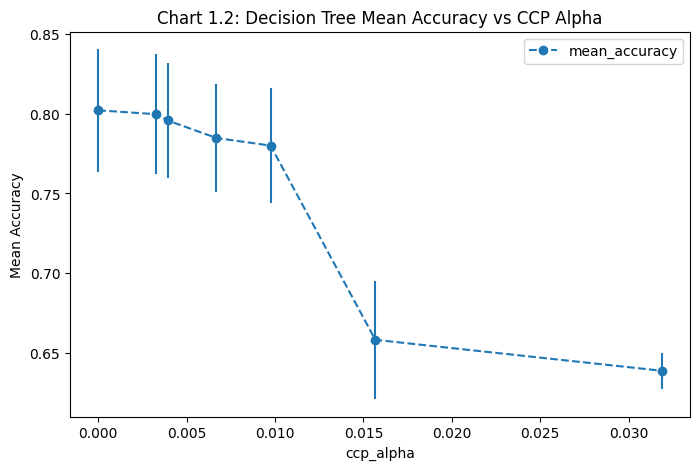

In [67]:
# loop through our ccp_alphas and build a decision tree for each corresponding ccp_alpha,
# then store its  accuracy score in a lists
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=13, ccp_alpha=ccp_alpha, criterion='gini', min_impurity_decrease=0.003)
    scores = cross_val_score(clf_dt, X_train_resampled, y_train_resampled, cv=10)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values, columns=['alpha','mean_accuracy', 'std'])

ax = alpha_results.plot(
    x='alpha',
    y='mean_accuracy',
    yerr='std',
    marker='o',
    linestyle='--',
    figsize=(8,5)
)
ax.set_title("Chart 1.2: Decision Tree Mean Accuracy vs CCP Alpha")
ax.set_xlabel("ccp_alpha")
ax.set_ylabel("Mean Accuracy")
plt.show()


A 10 k-fold Cross-Validation shows that the model scores best with an alpha between 0 and 0.003. The accuracy begins to declien faster somewhere in the range of .003 and .004. The mean accuracy score, however, is not 100%, suggesting that the model is not overfitted. This is assisted by the 10 k-fold CV, which helps generalize our model.

### Q1.3b - Can we get a more accurate best CCP alpha by using Grid Search Cross-Validation?

In [49]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=13),
    param_grid={'ccp_alpha': ccp_alphas},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['ccp_alpha']
print(f"Best ccp_alpha found by GridSearchCV: {best_alpha:.6f}")

Best ccp_alpha found by GridSearchCV: 0.003271


### Q1.3c - Can we get a more precise best min_impurity_decrease by using Grid Search Cross-Validation?

In [50]:
### 1.3 Find Min Impurity Decrease 
grid_search = GridSearchCV(
    estimator = DecisionTreeClassifier(random_state=13),
    param_grid = {'min_impurity_decrease': np.linspace(0.0, 0.05, 10)},
    cv=5,
    scoring='accuracy',
    n_jobs=-1 
)

grid_search.fit(X_train, y_train)
best_mid = grid_search.best_params_['min_impurity_decrease']
print(f"Optimal min_impurity_decrease found by GridSearchCV: {best_mid:.6f}")




Optimal min_impurity_decrease found by GridSearchCV: 0.005556


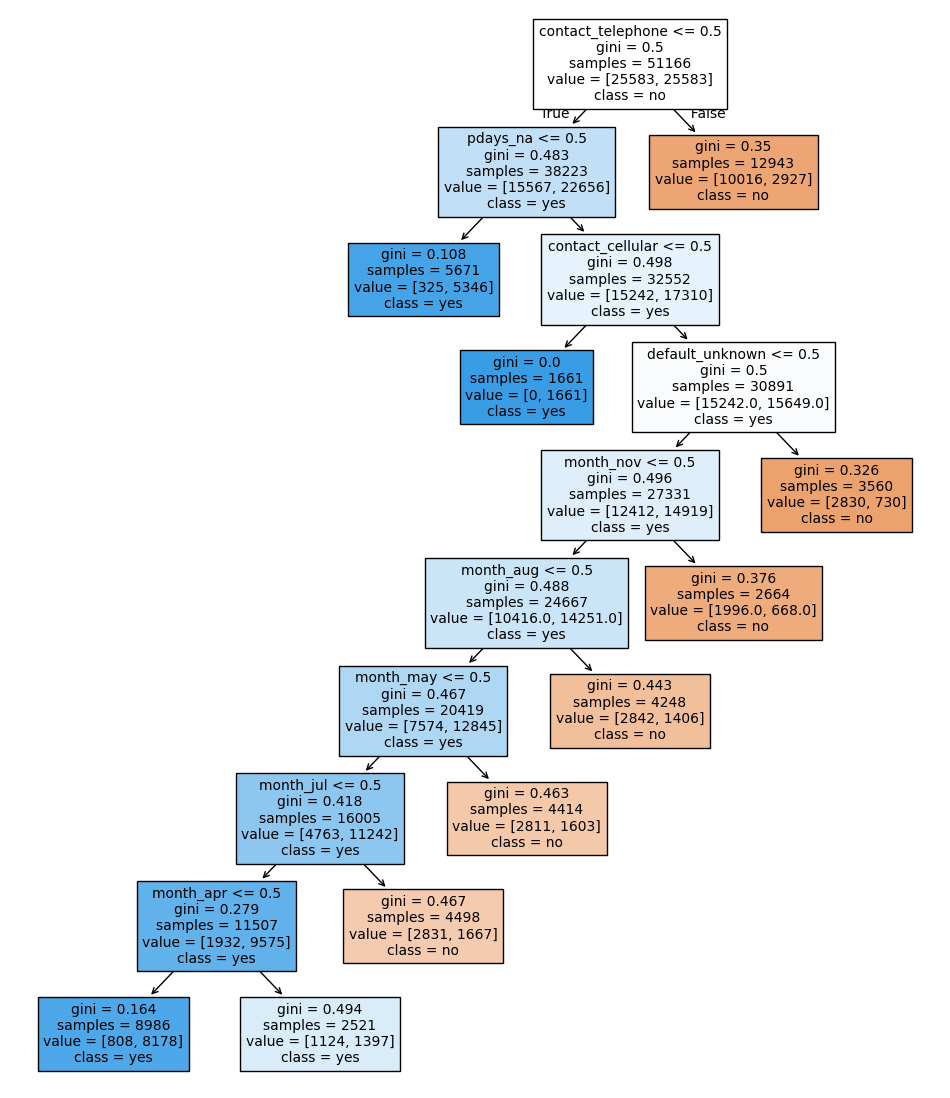

In [69]:
# update tree using best impurity and alpha values
dt2 = DecisionTreeClassifier(random_state=13, criterion='gini', min_impurity_decrease=best_mid, ccp_alpha=best_alpha)
dt2.fit(X_train_resampled, y_train_resampled)
y_pred = dt2.predict(X_test)

plt.figure(figsize=(12, 14))
plot_tree(dt2, 
               feature_names=all_predictors,
               class_names=dt2.classes_,
               filled=True, 
               fontsize=10)
plt.show()


In [68]:
dt2_y_pred = dt2.predict(X_test)
print('Confusion Matrix for Baseline Decision Tree\n', confusion_matrix(y_test, dt2_y_pred))
print("\nAccuracy:", accuracy_score(y_test, dt2_y_pred))
print('\nTesting Metrics for Baseline Decision Tree\n',classification_report(y_test, dt2_y_pred))

# show the features sorted greastest by their importance to the base model
features = pd.DataFrame(dt2.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print('\n\nFeatures Sorted by Importance to Model\n', features.sort_values(by='importance', ascending=False))

print('# important features', len(features[features['importance'] > 0]))
print('Total features', len(features))

Confusion Matrix for Baseline Decision Tree
 [[9974  991]
 [ 743  649]]

Accuracy: 0.8596746783199806

Testing Metrics for Baseline Decision Tree
               precision    recall  f1-score   support

          no       0.93      0.91      0.92     10965
         yes       0.40      0.47      0.43      1392

    accuracy                           0.86     12357
   macro avg       0.66      0.69      0.67     12357
weighted avg       0.87      0.86      0.86     12357



Features Sorted by Importance to Model
                       importance
contact_telephone       0.272384
pdays_na                0.170958
month_jul               0.144380
month_may               0.083469
contact_cellular        0.080444
default_unknown         0.076690
month_aug               0.065502
month_nov               0.053889
month_apr               0.052285
age                     0.000000
loan_no                 0.000000
loan_unknown            0.000000
loan_yes                0.000000
month_dec             

### Q1.4 - How does a model that doesn't incorporate time (ie month) compare to our current best model?


Testing Metrics for Decision Tree 2
               precision    recall  f1-score   support

          no       0.95      0.50      0.65     10965
         yes       0.16      0.78      0.27      1392

    accuracy                           0.53     12357
   macro avg       0.56      0.64      0.46     12357
weighted avg       0.86      0.53      0.61     12357



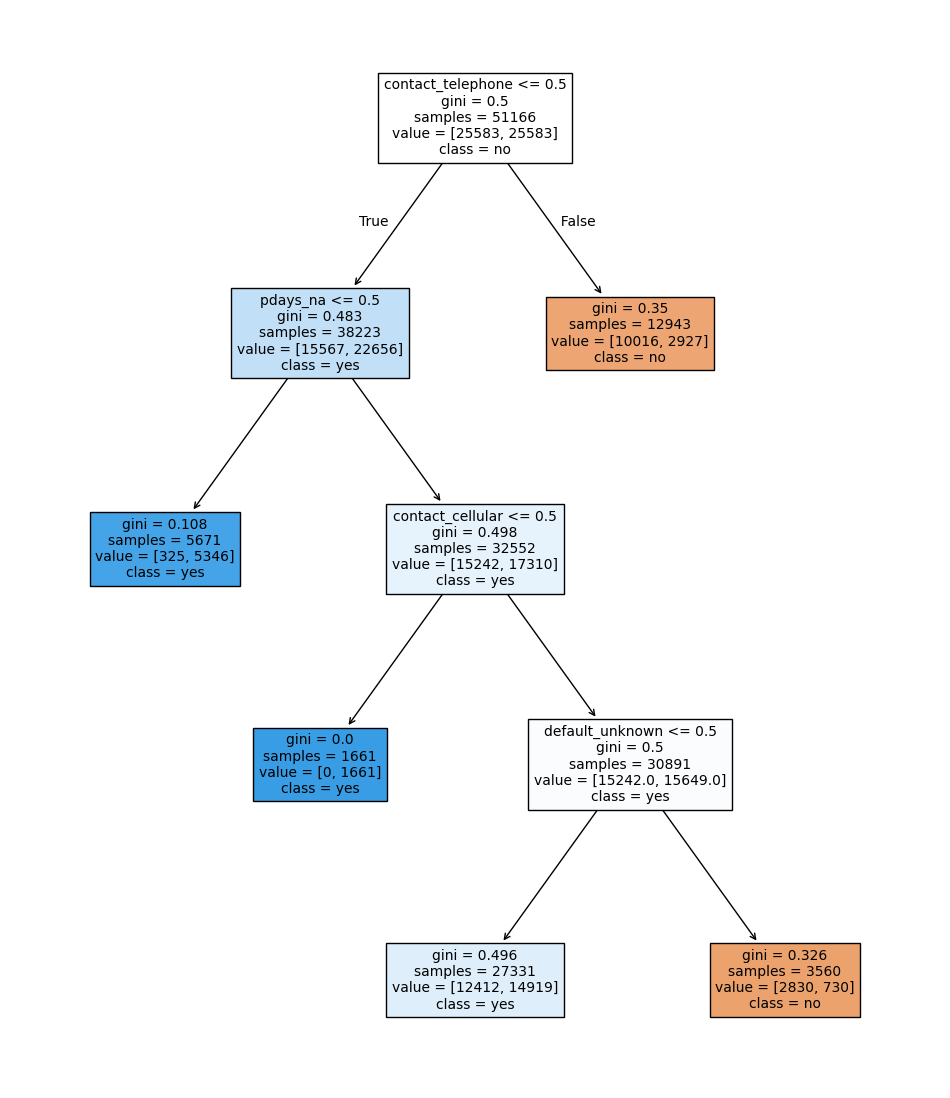


Features Sorted by Importance to Model
                       importance
contact_telephone       0.453613
pdays_na                0.284704
contact_cellular        0.133967
default_unknown         0.127716
age                     0.000000
month_jun               0.000000
loan_no                 0.000000
loan_unknown            0.000000
loan_yes                0.000000
month_apr               0.000000
month_aug               0.000000
month_dec               0.000000
month_jul               0.000000
month_mar               0.000000
month_may               0.000000
month_nov               0.000000
month_oct               0.000000
month_sep               0.000000
pdays_1                 0.000000
pdays_2                 0.000000
pdays_3                 0.000000
poutcome_failure        0.000000
poutcome_nonexistent    0.000000
default_yes             0.000000
default_no              0.000000
campaign                0.000000
job_student             0.000000
previous                0.000000
jo

In [ ]:

# limit depth of tree to 4 so that model stops before evaluating months
dt3 = DecisionTreeClassifier(random_state=13, criterion='gini', min_impurity_decrease=best_mid, ccp_alpha=best_alpha, max_depth=4)
dt3.fit(X_train_resampled, y_train_resampled)
plt.figure(figsize=(12, 14))
plot_tree(dt3, 
               feature_names=all_predictors,
               class_names=dt3.classes_,
               filled=True, 
               fontsize=10)
plt.show()


In [73]:

dt3_y_pred = dt3.predict(X_test)
print('Confusion Matrix for Baseline Decision Tree\n', confusion_matrix(y_test, dt3_y_pred))
print("\nAccuracy:", accuracy_score(y_test, dt3_y_pred))
print('\nTesting Metrics for Decision Tree 2\n', classification_report(y_test,dt3_y_pred))

features_dt3 = pd.DataFrame(dt3.feature_importances_, index=X_train_resampled.columns, columns=['importance'])
print('\nFeatures Sorted by Importance to Model\n', features_dt3.sort_values(by='importance', ascending=False))

Confusion Matrix for Baseline Decision Tree
 [[5450 5515]
 [ 309 1083]]

Accuracy: 0.5286881929270859

Testing Metrics for Decision Tree 2
               precision    recall  f1-score   support

          no       0.95      0.50      0.65     10965
         yes       0.16      0.78      0.27      1392

    accuracy                           0.53     12357
   macro avg       0.56      0.64      0.46     12357
weighted avg       0.86      0.53      0.61     12357


Features Sorted by Importance to Model
                       importance
contact_telephone       0.453613
pdays_na                0.284704
contact_cellular        0.133967
default_unknown         0.127716
age                     0.000000
month_jun               0.000000
loan_no                 0.000000
loan_unknown            0.000000
loan_yes                0.000000
month_apr               0.000000
month_aug               0.000000
month_dec               0.000000
month_jul               0.000000
month_mar               0.0000

## 2. Random Forest

### Q2.1 - Does using a different criterion result in better prediction accuracy?

In [74]:
from sklearn.ensemble import RandomForestClassifier

# Test the gini vs. entropy criterion
# find the best n_estimator size by comparing the OOB scores of many forests
n_estimator = list(range(50, 501, 50))
oobScores_gini = []
oobScores_ent = []
for n in n_estimator:
    rf_g = RandomForestClassifier(n_estimators=n, random_state=13, oob_score=True, bootstrap=True)
    rf_g.fit(X_train_resampled, y_train_resampled)
    oobScores_gini.append(rf_g.oob_score_)

    rf_e = RandomForestClassifier(n_estimators=n, criterion='entropy',  random_state=13, oob_score=True, bootstrap=True)
    rf_e.fit(X_train_resampled, y_train_resampled)
    oobScores_ent.append(rf_e.oob_score_)


gini_df = pd.DataFrame({ 'n_estimator' : n_estimator, 'Gini_OOBs' : oobScores_gini })
ent_df = pd.DataFrame({ 'n_estimator' : n_estimator, 'Entropy_OBBs' : oobScores_ent })


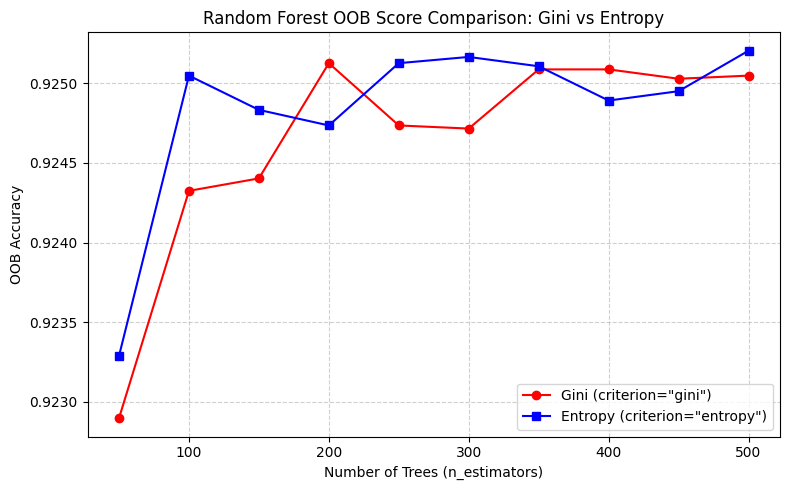


OBB Score Differences by criterion 
    n_estimator  Gini_OOBs  Entropy_OBBs  Difference
0           50   0.922898      0.923289   -0.000391
1          100   0.924325      0.925048   -0.000723
2          150   0.924403      0.924833   -0.000430
3          200   0.925126      0.924735    0.000391
4          250   0.924735      0.925126   -0.000391
5          300   0.924716      0.925165   -0.000450
6          350   0.925087      0.925107   -0.000020
7          400   0.925087      0.924892    0.000195
8          450   0.925028      0.924950    0.000078
9          500   0.925048      0.925204   -0.000156


In [ ]:

# plot differences between gini vs entropy
plt.figure(figsize=(8, 5))
plt.plot(gini_df['n_estimator'], gini_df['Gini_OOBs'], color='red', marker='o', label='Gini (criterion="gini")')
plt.plot(ent_df['n_estimator'], ent_df['Entropy_OBBs'], color='blue', marker='s', label='Entropy (criterion="entropy")')
plt.title('Random Forest OOB Score Comparison: Gini vs Entropy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('OOB Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# print comparison table
oob_scores = pd.merge(gini_df, ent_df, left_on='n_estimator', right_on='n_estimator', how='left')
oob_scores['Difference'] = oob_scores['Gini_OOBs'] - oob_scores['Entropy_OBBs']
print('\nOBB Score Differences by criterion \n', oob_scores)


Max accuracy for both Gini and Entropy is 450.

Testing the n_estimator values for Gini and Entropy produce interesting results. Unexpectedly, "Gini" produced higher accuracy levels than "Entropy". Both achieved maximum accuracy when n=450 at 0.924735 for Gini and 0.925380 for Entropy,

In [ ]:
# init RF using best n_estimator
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=450, random_state=1, oob_score=True)
rf.fit(X_train_resampled, y_train_resampled)


,n_estimators,450
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


### 
#### Q: how does OOB compare with CV?

### Q2.2. - Does Cross-Validation confirm the reliability of our Gini scores?

In [ ]:
# loop through list of estimators and perform 5 k-Fold cross validation
# save results to list
oobScores_cv = []
for n in n_estimator:
    
    rf_cv = RandomForestClassifier(
        n_estimators=n,
        random_state=13,
        n_jobs=-1
    )
    scores = cross_val_score(rf_cv, X_train_resampled, y_train_resampled, cv=5)
    oobScores_cv.append(scores.mean())


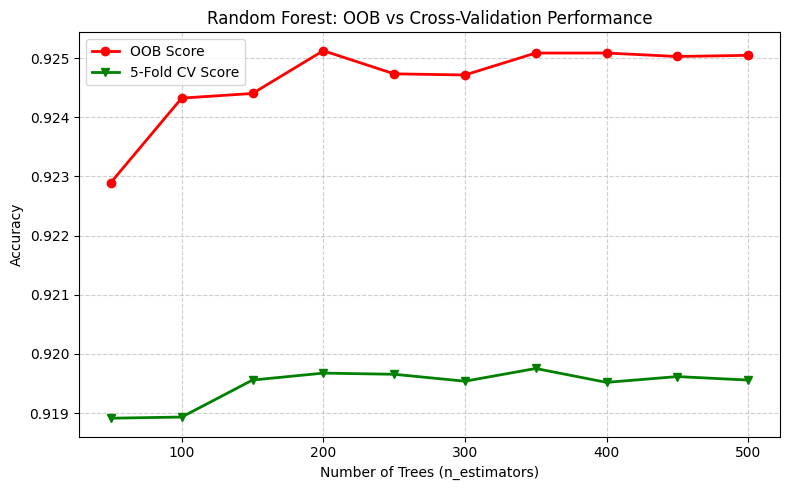


OBB Score Differences by criterion 
    n_estimator  Gini_OOBs  5-Fold CV Score  Difference
0           50   0.922898         0.918914    0.003984
1          100   0.924325         0.918933    0.005392
2          150   0.924403         0.919558    0.004844
3          200   0.925126         0.919676    0.005450
4          250   0.924735         0.919656    0.005079
5          300   0.924716         0.919539    0.005177
6          350   0.925087         0.919754    0.005333
7          400   0.925087         0.919519    0.005568
8          450   0.925028         0.919617    0.005411
9          500   0.925048         0.919559    0.005489


In [ ]:
# plot cv vs 
plt.figure(figsize=(8, 5))
plt.plot(n_estimator, oobScores_gini, color='red', marker='o',  label='OOB Score', linewidth=2)
plt.plot(n_estimator, oobScores_cv,  color='green', marker='v', label='5-Fold CV Score', linewidth=2)
plt.title('Random Forest: OOB vs Cross-Validation Performance')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# print comparison table
cv_df = pd.DataFrame({ 'n_estimator' : n_estimator, '5-Fold CV Score' : oobScores_cv })
oob_scores = pd.merge(gini_df, cv_df, left_on='n_estimator', right_on='n_estimator', how='left')
oob_scores['Difference'] = oob_scores['Gini_OOBs'] - oob_scores['5-Fold CV Score']
print('\nOBB Score Differences by criterion \n', oob_scores)

CV test values are within .0025 and .0054 difference, n_estimator of 450 still seems to be a good etimate

### Q2.3 - Does using a pipeline for preprocessing instead of performaning manual preprocessing reduce the difference between our Gini Values and our Cross-Validation?

In [ ]:
from sklearn.pipeline import Pipeline 
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# prep data for pipeline
df_no_preprocessing = df.copy()
df_no_preprocessing.drop(columns=["pdays_na"], inplace=True)
df_no_preprocessing['pdays'] = df_no_preprocessing['pdays'].cat.add_categories([-1])
df_no_preprocessing['pdays'] = df_no_preprocessing['pdays'].fillna(-1)


# split categorical and numerical features
numeric_cols = df_no_preprocessing.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'y']
categorical_cols = df_no_preprocessing.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('y')

# enforce that object types are treated as categorical
for col in categorical_cols:
    df_no_preprocessing[col] = df_no_preprocessing[col].astype('category')

#split our data
X2 = df_no_preprocessing.drop(['y'], axis=1)
y2 = df_no_preprocessing['y']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=13, stratify=y)
   

In [ ]:
# Init pipeline: Preprocessing -> SMOTE -> Random Forest
rf1_pipe = ImbPipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols),
            ('num', SimpleImputer(strategy='constant', fill_value=0), numeric_cols)
        ]
    )),
    ('smote', SMOTE(random_state=13)),
    ('rf', RandomForestClassifier(
        n_estimators=450,
        random_state=13,
        n_jobs=-1
    ))
])

# Train our model
rf1_pipe.fit(X2_train, y2_train)


,steps,"[('preprocessor', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:

rf1_y_pred = rf1_pipe.predict(X2_test)

print("Accuracy:", accuracy_score(y_test, rf1_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf1_y_pred))

Accuracy: 0.8710042890669256

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.94      0.93     10965
         yes       0.40      0.31      0.35      1392

    accuracy                           0.87     12357
   macro avg       0.66      0.63      0.64     12357
weighted avg       0.86      0.87      0.86     12357



In [ ]:

# print out mean CV scores
# do I use train or test for cross_val_score?
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"CV Mean Score: {cv_scores.mean():.4f}")

cv_scores2 = cross_val_score(rf1_pipe, X2_train, y2_train, cv=5)
print(f"CV Mean Score (Pipeline): {cv_scores2.mean():.4f}")


CV Mean Score: 0.8799
CV Mean Score (Pipeline): 0.8738


In [ ]:

# get preprocessed values from out pipeline
X2_preprocessed = rf1_pipe.named_steps['preprocessor'].transform(X2_train)
X2_resampled, y2_resampled = rf1_pipe.named_steps['smote'].fit_resample(X2_preprocessed, y2_train)


Using a pipeline increases the difference between our OOB score and CV scores for our pipeline pre-processing vs manual pre-processing by ~4%. Suggests possible data leakage that could lead to overfitting; manual should be ignored.

### Q2.4 - How does selecting different subsampling affect model accuracy?

In [ ]:
max_features_options = ['sqrt', 'log2', 0.3, 0.5, None]
subsample_scores = []


for mf in max_features_options:
    rf_mf = RandomForestClassifier(
        n_estimators=450,
        max_features=mf,
        oob_score=True,
        random_state=13,
        n_jobs=-1
    )
    # how do I fit training samples from pipeline?
    rf_mf.fit(X2_resampled, y2_resampled)

    oob = rf_mf.oob_score_
    subsample_scores.append(oob if oob is not None else 0) 
    print(f"max_features={mf}: OOB Score = {oob}")




max_features=sqrt: OOB Score = 0.930383457764922
max_features=log2: OOB Score = 0.9309893288511902
max_features=0.3: OOB Score = 0.9300316616503147
max_features=0.5: OOB Score = 0.9303052808505649
max_features=None: OOB Score = 0.927432279247938


In [ ]:
# Init pipeline: Preprocessing -> SMOTE -> Random Forest
rf2_pipe = ImbPipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols),
            ('num', SimpleImputer(strategy='constant', fill_value=0), numeric_cols)
        ]
    )),
    ('smote', SMOTE(random_state=13)),
    ('rf', RandomForestClassifier(
        n_estimators=450,
        random_state=13,
        n_jobs=-1
    ))
])


# Train our model
rf2_pipe.fit(X2_train, y2_train)
rf2_y_pred = rf2_pipe.predict(X2_test)

print("Accuracy:", accuracy_score(y_test, rf2_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf2_y_pred))


Accuracy: 0.8710042890669256

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.94      0.93     10965
         yes       0.40      0.31      0.35      1392

    accuracy                           0.87     12357
   macro avg       0.66      0.63      0.64     12357
weighted avg       0.86      0.87      0.86     12357



In [ ]:
#Evaluate

rf2_y_pred = rf2_pipe.predict(X2_test)

print("Accuracy:", accuracy_score(y2_test, rf2_y_pred))
print("\nClassification Report:\n", classification_report(y_test, rf2_y_pred))
#How do I evaluate predictions

Accuracy: 0.8710042890669256

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.94      0.93     10965
         yes       0.40      0.31      0.35      1392

    accuracy                           0.87     12357
   macro avg       0.66      0.63      0.64     12357
weighted avg       0.86      0.87      0.86     12357



## 3. AdaBoost

### Build Baseline AdaBoost Model

In [ ]:
# Use GridSearch to get best n_estimator value
from sklearn.ensemble import AdaBoostClassifier

base_tree = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(estimator=base_tree, random_state=13)

param_grid = {
    'n_estimators': n_estimator
}

grid = GridSearchCV(ada, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X2_resampled, y2_resampled)

print("Best hyperparameters:", grid.best_params_)
print("Best CV score:", grid.best_score_)

# Best AdaBoost model
best_ada = grid.best_estimator_

print("Number of weak learners:", len(best_ada.estimators_))
print("Weights of weak learners:", best_ada.estimator_weights_)

Best hyperparameters: {'n_estimators': 500}
Best CV score: 0.9103150053050613
Number of weak learners: 500
Weights of weak learners: [0.57229132 0.61556081 0.45653241 0.24754967 0.39343194 0.29830187
 0.1556457  0.24393631 0.20760774 0.27368956 0.2586611  0.24005996
 0.25987961 0.09528803 0.15721479 0.17875584 0.31844989 0.23074646
 0.25893474 0.27270947 0.26671253 0.125749   0.23995984 0.23379667
 0.13522178 0.16789831 0.1181586  0.12164123 0.19474078 0.21350274
 0.07462769 0.09785638 0.11734506 0.14861723 0.26361761 0.23277818
 0.22938083 0.1664593  0.13475048 0.14777806 0.11006152 0.09340388
 0.10672207 0.09024002 0.1225877  0.09377799 0.13090662 0.09576302
 0.10521112 0.08401625 0.12498444 0.08739175 0.09263806 0.07874037
 0.07901767 0.07029783 0.08872021 0.07508267 0.05294742 0.11429345
 0.20879898 0.18900226 0.11960377 0.11318436 0.08214641 0.0875763
 0.1778677  0.23823841 0.21278444 0.19225968 0.12748209 0.12480547
 0.21290206 0.19235563 0.09072432 0.1009291  0.07985708 0.082148

In [ ]:
best_estimator = len(best_ada.estimators_)
ada1_pipe = ImbPipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols),
            ('num', SimpleImputer(strategy='constant', fill_value=0), numeric_cols)
        ]
    )),
    ('smote', SMOTE(random_state=13)),
    ('ada', AdaBoostClassifier(estimator=base_tree, n_estimators=best_estimator, learning_rate=0.1, random_state=1))
])

ada1_pipe.fit(X2_train, y2_train)
ada_y_pred = ada1_pipe.predict(X2_test)

print("Accuracy:", accuracy_score(y_test, ada_y_pred))
print("\nClassification Report:\n", classification_report(y_test, ada_y_pred))




Accuracy: 0.7922634943756576

Classification Report:
               precision    recall  f1-score   support

          no       0.94      0.82      0.88     10965
         yes       0.29      0.57      0.38      1392

    accuracy                           0.79     12357
   macro avg       0.61      0.70      0.63     12357
weighted avg       0.86      0.79      0.82     12357



In [ ]:
# get preprocessed values from out pipeline
X2_preprocessed = ada1_pipe.named_steps['preprocessor'].transform(X2_train)
X2_resampled, y2_resampled = ada1_pipe.named_steps['smote'].fit_resample(X2_preprocessed, y2_train)

### Q3.1 - How does stump depth affect the model? 

In [ ]:
max_depths = [1, 2, 3, 4, 5, 6]
mean_cv_scores = []

for depth in max_depths:
    
    base_tree = DecisionTreeClassifier(max_depth=depth, random_state=13)
    
    ada = AdaBoostClassifier(
        estimator=base_tree,
        n_estimators=best_estimator,
        learning_rate=0.5,
        random_state=13
    )
    
    scores = cross_val_score(ada, X2_resampled, y2_resampled, cv=5, scoring='accuracy')
    mean_cv_scores.append(np.mean(scores))


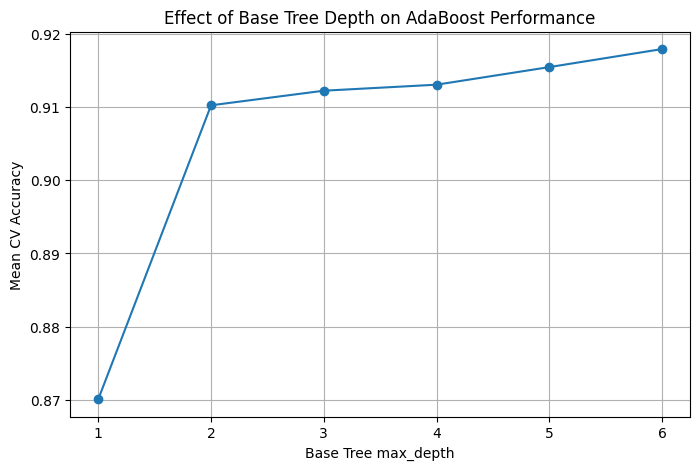

Best tree depth: 6
Best mean CV accuracy: 0.9179


In [ ]:

# Plot results
plt.figure(figsize=(8,5))
plt.plot(max_depths, mean_cv_scores, marker='o')
plt.title("Effect of Base Tree Depth on AdaBoost Performance")
plt.xlabel("Base Tree max_depth")
plt.ylabel("Mean CV Accuracy")
plt.grid(True)
plt.show()

# Best depth
best_depth = max_depths[np.argmax(mean_cv_scores)]
print(f"Best tree depth: {best_depth}")
print(f"Best mean CV accuracy: {max(mean_cv_scores):.4f}")

### Q3.2 - How does stump depth affect the model? 

In [ ]:
#
learning_rates = np.linspace(0.01, 2.0, 20)
ada_lr_scores = []


base_tree2 = DecisionTreeClassifier(max_depth=2, random_state=13)

for lr in learning_rates:
    ada = AdaBoostClassifier(
        estimator=base_tree2,
        n_estimators=best_estimator,
        learning_rate=lr,
        random_state=13
    )
    cv_score = cross_val_score(ada, X2_resampled, y2_resampled, cv=5, scoring='accuracy').mean()
    ada_lr_scores.append(cv_score)


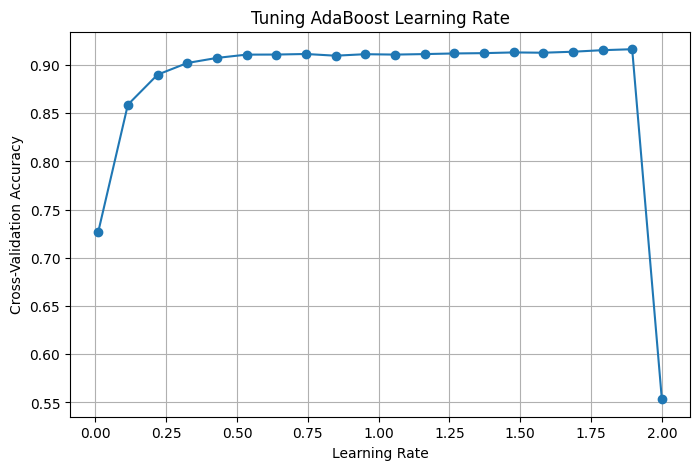

Best learning rate: 1.90
Best CV accuracy: 0.9165


In [ ]:
# plot tuning
plt.figure(figsize=(8,5))
plt.plot(learning_rates, ada_lr_scores, marker='o')
plt.title("Tuning AdaBoost Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.show()

best_lr = learning_rates[np.argmax(ada_lr_scores)]
print(f"Best learning rate: {best_lr:.2f}")
print(f"Best CV accuracy: {max(ada_lr_scores):.4f}")

In [ ]:
best_estimator = len(best_ada.estimators_)
ada2_pipe = ImbPipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
            ]), categorical_cols),
            ('num', SimpleImputer(strategy='constant', fill_value=0), numeric_cols)
        ]
    )),
    ('smote', SMOTE(random_state=13)),
    ('ada', AdaBoostClassifier(estimator=base_tree2, n_estimators=best_estimator, learning_rate=best_lr, random_state=13))
])

ada2_pipe.fit(X2_train, y2_train)
ada2_y_pred = ada2_pipe.predict(X2_test)

print("Accuracy:", accuracy_score(y_test, ada2_y_pred))
print("\nClassification Report:\n", classification_report(y_test, ada2_y_pred))

Accuracy: 0.8894553694262362

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.97      0.94     10965
         yes       0.52      0.24      0.33      1392

    accuracy                           0.89     12357
   macro avg       0.71      0.60      0.63     12357
weighted avg       0.87      0.89      0.87     12357

